In [16]:
!pip install vizdoom opencv-python torch torchvision tqdm
import vizdoom as vzd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from tqdm import trange
import cv2
import matplotlib.pyplot as plt
import os



In [17]:
cadr = 4
shape_r = (64, 64)
memor = 10000
batch_si = 32
ler_rate = 1e-4
Gamma = 0.99
ep_st = 1.0
eps_en = 0.1
eps_de = 100000
tar_up= 1000
num_ep = 200

In [18]:
#создание среды
def create_env():
    game = vzd.DoomGame()
    game.set_doom_scenario_path("defend_the_center.wad")
    game.set_doom_map("map01")
    game.set_screen_resolution(vzd.ScreenResolution.RES_160X120)
    game.set_screen_format(vzd.ScreenFormat.RGB24)
    game.set_render_hud(False)
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)
    game.set_render_particles(False)

    game.set_available_buttons([vzd.Button.TURN_LEFT, vzd.Button.TURN_RIGHT, vzd.Button.ATTACK])
    game.set_episode_timeout(2100)
    game.set_episode_start_time(10)
    game.set_window_visible(False)
    game.set_sound_enabled(False)
    game.init()
    return game

In [19]:
#Предобработка кадра
def preprocess(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, shape_r)
    return resized / 255.0


In [20]:
#Q сеть
class DQN(nn.Module):
    def __init__(self, n_actions, input_shape=(4, 64, 64)):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [21]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [22]:
# Обучение агента
def train():
    game = create_env()
    n_actions = game.get_available_buttons_size()

    policy_net = DQN(n_actions).cuda()
    target_net = DQN(n_actions).cuda()
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=ler_rate)
    memory = ReplayMemory(memor)

    steps_done = 0
    epsilon = ep_st
    episode_rewards = []

    for episode in trange(num_ep):
        game.new_episode()
        state = preprocess(game.get_state().screen_buffer)
        state_stack = np.stack([state] * 4, axis=0)

        total_reward = 0
        while not game.is_episode_finished():
            steps_done += 1
            epsilon = max(eps_en, ep_st - steps_done / eps_de)

            if random.random() < epsilon:
                action_idx = random.randrange(n_actions)
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor([state_stack], dtype=torch.float32).cuda()
                    q_values = policy_net(state_tensor)
                    action_idx = q_values.argmax().item()

            action = [0] * n_actions
            action[action_idx] = 1
            reward = game.make_action(action, cadr)
            done = game.is_episode_finished()

            if not done:
                next_state = preprocess(game.get_state().screen_buffer)
                next_state_stack = np.roll(state_stack, -1, axis=0)
                next_state_stack[-1] = next_state
            else:
                next_state_stack = np.zeros_like(state_stack)

            memory.push((state_stack, action_idx, reward, next_state_stack, done))
            state_stack = next_state_stack
            total_reward += reward

            if len(memory) >= batch_si:
                transitions = memory.sample(batch_si)
                states, actions, rewards, next_states, dones = zip(*transitions)

                states = torch.tensor(states, dtype=torch.float32).cuda()
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).cuda()
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).cuda()
                next_states = torch.tensor(next_states, dtype=torch.float32).cuda()
                dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).cuda()

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                expected_q = rewards + Gamma * next_q_values * (~dones)

                loss = nn.MSELoss()(q_values, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if steps_done % tar_up == 0:
                target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1} | Total reward: {total_reward}")

    torch.save(policy_net.state_dict(), "dqn_defend_model.pth")
    game.close()

    # График
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Total Reward per Episode')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
#Демонстрация и Сохранение видео

def test(save_video=True, video_filename="agent_play.avi"):
    game = create_env()
    n_actions = game.get_available_buttons_size()

    model = DQN(n_actions).cuda()
    model.load_state_dict(torch.load("dqn_defend_model.pth"))
    model.eval()

    game.set_window_visible(True)

    # Видео запись
    if save_video:
        fps = 30
        width, height = 160, 120
        out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*"XVID"), fps, (width, height))

    for _ in range(1):
        game.new_episode()
        state = preprocess(game.get_state().screen_buffer)
        state_stack = np.stack([state] * 4, axis=0)

        while not game.is_episode_finished():
            state_tensor = torch.tensor([state_stack], dtype=torch.float32).cuda()
            with torch.no_grad():
                q_values = model(state_tensor)
                action_idx = q_values.argmax().item()

            action = [0] * n_actions
            action[action_idx] = 1
            game.make_action(action, cadr)

            if not game.is_episode_finished():
                screen = game.get_state().screen_buffer
                frame = cv2.cvtColor(screen, cv2.COLOR_RGB2BGR)
                if save_video:
                    out.write(frame)

                next_state = preprocess(screen)
                state_stack = np.roll(state_stack, -1, axis=0)
                state_stack[-1] = next_state

    game.close()
    if save_video:
        out.release()
        print(f"🎬 Видео сохранено: {video_filename}")

  0%|          | 1/200 [00:17<57:16, 17.27s/it]

Episode 1 | Total reward: 1.0


  1%|          | 2/200 [00:33<54:05, 16.39s/it]

Episode 2 | Total reward: 1.0


  2%|▏         | 3/200 [00:47<51:18, 15.63s/it]

Episode 3 | Total reward: 3.0


  2%|▏         | 4/200 [00:57<43:14, 13.24s/it]

Episode 4 | Total reward: 0.0


  2%|▎         | 5/200 [01:09<41:25, 12.75s/it]

Episode 5 | Total reward: 1.0


  3%|▎         | 6/200 [01:29<49:25, 15.29s/it]

Episode 6 | Total reward: 4.0


  4%|▎         | 7/200 [01:47<52:10, 16.22s/it]

Episode 7 | Total reward: 2.0


  4%|▍         | 8/200 [02:03<51:20, 16.04s/it]

Episode 8 | Total reward: 3.0


  4%|▍         | 9/200 [02:18<49:50, 15.66s/it]

Episode 9 | Total reward: 2.0


  5%|▌         | 10/200 [02:32<48:50, 15.42s/it]

Episode 10 | Total reward: 1.0


  6%|▌         | 11/200 [02:44<44:36, 14.16s/it]

Episode 11 | Total reward: 2.0


  6%|▌         | 12/200 [02:55<41:34, 13.27s/it]

Episode 12 | Total reward: 2.0


  6%|▋         | 13/200 [03:05<38:00, 12.19s/it]

Episode 13 | Total reward: 0.0


  7%|▋         | 14/200 [03:20<40:35, 13.09s/it]

Episode 14 | Total reward: 2.0


  8%|▊         | 15/200 [03:36<43:10, 14.00s/it]

Episode 15 | Total reward: 1.0


  8%|▊         | 16/200 [03:48<40:50, 13.32s/it]

Episode 16 | Total reward: 2.0


  8%|▊         | 17/200 [03:57<37:04, 12.16s/it]

Episode 17 | Total reward: 0.0


  9%|▉         | 18/200 [04:07<35:06, 11.57s/it]

Episode 18 | Total reward: 1.0


 10%|▉         | 19/200 [04:19<34:50, 11.55s/it]

Episode 19 | Total reward: 2.0


 10%|█         | 20/200 [04:29<32:58, 10.99s/it]

Episode 20 | Total reward: 0.0


 10%|█         | 21/200 [04:39<32:39, 10.95s/it]

Episode 21 | Total reward: 0.0


 11%|█         | 22/200 [04:55<36:43, 12.38s/it]

Episode 22 | Total reward: 2.0


 12%|█▏        | 23/200 [05:07<36:00, 12.20s/it]

Episode 23 | Total reward: 0.0


 12%|█▏        | 24/200 [05:16<32:50, 11.19s/it]

Episode 24 | Total reward: 1.0


 12%|█▎        | 25/200 [05:28<33:12, 11.39s/it]

Episode 25 | Total reward: 1.0


 13%|█▎        | 26/200 [05:42<35:23, 12.21s/it]

Episode 26 | Total reward: 1.0


 14%|█▎        | 27/200 [05:51<32:40, 11.33s/it]

Episode 27 | Total reward: 1.0


 14%|█▍        | 28/200 [06:07<36:18, 12.67s/it]

Episode 28 | Total reward: 2.0


 14%|█▍        | 29/200 [06:21<37:19, 13.10s/it]

Episode 29 | Total reward: 0.0


 15%|█▌        | 30/200 [06:31<34:10, 12.06s/it]

Episode 30 | Total reward: 0.0


 16%|█▌        | 31/200 [06:46<36:33, 12.98s/it]

Episode 31 | Total reward: 2.0


 16%|█▌        | 32/200 [06:57<34:45, 12.41s/it]

Episode 32 | Total reward: 2.0


 16%|█▋        | 33/200 [07:09<34:29, 12.39s/it]

Episode 33 | Total reward: 2.0


 17%|█▋        | 34/200 [07:24<36:16, 13.11s/it]

Episode 34 | Total reward: 1.0


 18%|█▊        | 35/200 [07:35<34:15, 12.46s/it]

Episode 35 | Total reward: 1.0


 18%|█▊        | 36/200 [07:50<36:13, 13.25s/it]

Episode 36 | Total reward: 1.0


 18%|█▊        | 37/200 [07:59<33:00, 12.15s/it]

Episode 37 | Total reward: 0.0


 19%|█▉        | 38/200 [08:16<36:08, 13.38s/it]

Episode 38 | Total reward: 2.0


 20%|█▉        | 39/200 [08:27<33:59, 12.67s/it]

Episode 39 | Total reward: 0.0


 20%|██        | 40/200 [08:39<33:31, 12.57s/it]

Episode 40 | Total reward: 1.0


 20%|██        | 41/200 [08:54<35:12, 13.28s/it]

Episode 41 | Total reward: 2.0


 21%|██        | 42/200 [09:07<34:54, 13.26s/it]

Episode 42 | Total reward: 2.0


 22%|██▏       | 43/200 [09:19<33:35, 12.84s/it]

Episode 43 | Total reward: 1.0


 22%|██▏       | 44/200 [09:31<32:34, 12.53s/it]

Episode 44 | Total reward: 0.0


 22%|██▎       | 45/200 [09:46<34:11, 13.23s/it]

Episode 45 | Total reward: 1.0


 23%|██▎       | 46/200 [09:59<34:03, 13.27s/it]

Episode 46 | Total reward: 2.0


 24%|██▎       | 47/200 [10:12<33:46, 13.24s/it]

Episode 47 | Total reward: 1.0


 24%|██▍       | 48/200 [10:24<32:28, 12.82s/it]

Episode 48 | Total reward: 1.0


 24%|██▍       | 49/200 [10:37<31:58, 12.70s/it]

Episode 49 | Total reward: 1.0


 25%|██▌       | 50/200 [10:49<31:33, 12.62s/it]

Episode 50 | Total reward: 1.0


 26%|██▌       | 51/200 [11:02<31:27, 12.67s/it]

Episode 51 | Total reward: 1.0


 26%|██▌       | 52/200 [11:21<36:05, 14.63s/it]

Episode 52 | Total reward: 2.0


 26%|██▋       | 53/200 [11:35<35:33, 14.51s/it]

Episode 53 | Total reward: 2.0


 27%|██▋       | 54/200 [11:52<36:42, 15.08s/it]

Episode 54 | Total reward: 2.0


 28%|██▊       | 55/200 [12:03<33:23, 13.82s/it]

Episode 55 | Total reward: 1.0


 28%|██▊       | 56/200 [12:14<31:25, 13.10s/it]

Episode 56 | Total reward: 1.0


 28%|██▊       | 57/200 [12:24<28:54, 12.13s/it]

Episode 57 | Total reward: 1.0


 29%|██▉       | 58/200 [12:33<26:49, 11.34s/it]

Episode 58 | Total reward: 1.0


 30%|██▉       | 59/200 [12:42<24:49, 10.56s/it]

Episode 59 | Total reward: 0.0


 30%|███       | 60/200 [12:56<27:14, 11.68s/it]

Episode 60 | Total reward: 2.0


 30%|███       | 61/200 [13:07<26:19, 11.36s/it]

Episode 61 | Total reward: 1.0


 31%|███       | 62/200 [13:19<26:29, 11.52s/it]

Episode 62 | Total reward: 0.0


 32%|███▏      | 63/200 [13:31<27:00, 11.83s/it]

Episode 63 | Total reward: 2.0


 32%|███▏      | 64/200 [13:47<29:43, 13.11s/it]

Episode 64 | Total reward: 1.0


 32%|███▎      | 65/200 [14:01<29:57, 13.32s/it]

Episode 65 | Total reward: 0.0


 33%|███▎      | 66/200 [14:14<29:05, 13.03s/it]

Episode 66 | Total reward: 2.0


 34%|███▎      | 67/200 [14:25<27:49, 12.55s/it]

Episode 67 | Total reward: 1.0


 34%|███▍      | 68/200 [14:39<28:11, 12.82s/it]

Episode 68 | Total reward: 1.0


 34%|███▍      | 69/200 [14:46<24:22, 11.17s/it]

Episode 69 | Total reward: 0.0


 35%|███▌      | 70/200 [15:00<26:03, 12.03s/it]

Episode 70 | Total reward: 1.0


 36%|███▌      | 71/200 [15:11<25:17, 11.77s/it]

Episode 71 | Total reward: 1.0


 36%|███▌      | 72/200 [15:24<25:39, 12.03s/it]

Episode 72 | Total reward: 1.0


 36%|███▋      | 73/200 [15:36<25:48, 12.19s/it]

Episode 73 | Total reward: 0.0


 37%|███▋      | 74/200 [15:51<27:15, 12.98s/it]

Episode 74 | Total reward: 2.0


 38%|███▊      | 75/200 [16:06<28:30, 13.68s/it]

Episode 75 | Total reward: 1.0


 38%|███▊      | 76/200 [16:16<25:43, 12.45s/it]

Episode 76 | Total reward: 0.0


 38%|███▊      | 77/200 [16:32<27:28, 13.40s/it]

Episode 77 | Total reward: 3.0


 39%|███▉      | 78/200 [16:47<28:37, 14.08s/it]

Episode 78 | Total reward: 1.0


 40%|███▉      | 79/200 [16:57<25:35, 12.69s/it]

Episode 79 | Total reward: 0.0


 40%|████      | 80/200 [17:10<25:35, 12.79s/it]

Episode 80 | Total reward: 1.0


 40%|████      | 81/200 [17:24<26:09, 13.19s/it]

Episode 81 | Total reward: 1.0


 41%|████      | 82/200 [17:36<25:35, 13.02s/it]

Episode 82 | Total reward: 1.0


 42%|████▏     | 83/200 [17:49<25:20, 13.00s/it]

Episode 83 | Total reward: 2.0


 42%|████▏     | 84/200 [18:01<24:17, 12.57s/it]

Episode 84 | Total reward: 1.0


 42%|████▎     | 85/200 [18:18<26:36, 13.88s/it]

Episode 85 | Total reward: 2.0


 43%|████▎     | 86/200 [18:30<25:20, 13.34s/it]

Episode 86 | Total reward: 1.0


 44%|████▎     | 87/200 [18:40<23:18, 12.37s/it]

Episode 87 | Total reward: 2.0


 44%|████▍     | 88/200 [18:50<21:31, 11.53s/it]

Episode 88 | Total reward: 0.0


 44%|████▍     | 89/200 [19:00<20:39, 11.17s/it]

Episode 89 | Total reward: 1.0


 45%|████▌     | 90/200 [19:15<22:24, 12.22s/it]

Episode 90 | Total reward: 4.0


 46%|████▌     | 91/200 [19:31<24:32, 13.51s/it]

Episode 91 | Total reward: 2.0


 46%|████▌     | 92/200 [19:44<23:51, 13.25s/it]

Episode 92 | Total reward: 1.0


 46%|████▋     | 93/200 [19:58<24:15, 13.60s/it]

Episode 93 | Total reward: 2.0


 47%|████▋     | 94/200 [20:14<25:04, 14.19s/it]

Episode 94 | Total reward: 2.0


 48%|████▊     | 95/200 [20:23<22:21, 12.78s/it]

Episode 95 | Total reward: 1.0


 48%|████▊     | 96/200 [20:41<24:51, 14.34s/it]

Episode 96 | Total reward: 4.0


 48%|████▊     | 97/200 [20:55<24:13, 14.12s/it]

Episode 97 | Total reward: 2.0


 49%|████▉     | 98/200 [21:08<23:38, 13.91s/it]

Episode 98 | Total reward: 1.0


 50%|████▉     | 99/200 [21:18<21:17, 12.65s/it]

Episode 99 | Total reward: 0.0


 50%|█████     | 100/200 [21:33<22:22, 13.42s/it]

Episode 100 | Total reward: 2.0


 50%|█████     | 101/200 [21:49<23:15, 14.10s/it]

Episode 101 | Total reward: 1.0


 51%|█████     | 102/200 [22:02<22:27, 13.75s/it]

Episode 102 | Total reward: 0.0


 52%|█████▏    | 103/200 [22:17<22:40, 14.02s/it]

Episode 103 | Total reward: 1.0


 52%|█████▏    | 104/200 [22:27<20:32, 12.84s/it]

Episode 104 | Total reward: 1.0


 52%|█████▎    | 105/200 [22:40<20:38, 13.03s/it]

Episode 105 | Total reward: 0.0


 53%|█████▎    | 106/200 [22:52<20:04, 12.81s/it]

Episode 106 | Total reward: 1.0


 54%|█████▎    | 107/200 [23:09<21:27, 13.85s/it]

Episode 107 | Total reward: 2.0


 54%|█████▍    | 108/200 [23:23<21:28, 14.01s/it]

Episode 108 | Total reward: 1.0


 55%|█████▍    | 109/200 [23:36<20:52, 13.76s/it]

Episode 109 | Total reward: 3.0


 55%|█████▌    | 110/200 [23:52<21:28, 14.32s/it]

Episode 110 | Total reward: 1.0


 56%|█████▌    | 111/200 [24:03<19:45, 13.32s/it]

Episode 111 | Total reward: 1.0


 56%|█████▌    | 112/200 [24:16<19:24, 13.23s/it]

Episode 112 | Total reward: 2.0


 56%|█████▋    | 113/200 [24:31<20:07, 13.88s/it]

Episode 113 | Total reward: 3.0


 57%|█████▋    | 114/200 [24:46<20:27, 14.27s/it]

Episode 114 | Total reward: 3.0


 57%|█████▊    | 115/200 [24:58<18:57, 13.38s/it]

Episode 115 | Total reward: 1.0


 58%|█████▊    | 116/200 [25:15<20:11, 14.42s/it]

Episode 116 | Total reward: 2.0


 58%|█████▊    | 117/200 [25:29<20:02, 14.49s/it]

Episode 117 | Total reward: 1.0


 59%|█████▉    | 118/200 [25:46<20:33, 15.04s/it]

Episode 118 | Total reward: 3.0


 60%|█████▉    | 119/200 [25:57<18:45, 13.90s/it]

Episode 119 | Total reward: 0.0


 60%|██████    | 120/200 [26:10<18:20, 13.75s/it]

Episode 120 | Total reward: 1.0


 60%|██████    | 121/200 [26:21<17:03, 12.96s/it]

Episode 121 | Total reward: 0.0


 61%|██████    | 122/200 [26:37<17:53, 13.77s/it]

Episode 122 | Total reward: 2.0


 62%|██████▏   | 123/200 [26:53<18:41, 14.57s/it]

Episode 123 | Total reward: 1.0


 62%|██████▏   | 124/200 [27:05<17:26, 13.76s/it]

Episode 124 | Total reward: 0.0


 62%|██████▎   | 125/200 [27:18<16:52, 13.50s/it]

Episode 125 | Total reward: 1.0


 63%|██████▎   | 126/200 [27:34<17:23, 14.10s/it]

Episode 126 | Total reward: 1.0


 64%|██████▎   | 127/200 [27:45<16:05, 13.23s/it]

Episode 127 | Total reward: 1.0


 64%|██████▍   | 128/200 [27:57<15:26, 12.86s/it]

Episode 128 | Total reward: 0.0


 64%|██████▍   | 129/200 [28:12<16:02, 13.56s/it]

Episode 129 | Total reward: 2.0


 65%|██████▌   | 130/200 [28:29<16:58, 14.55s/it]

Episode 130 | Total reward: 2.0


 66%|██████▌   | 131/200 [28:49<18:33, 16.14s/it]

Episode 131 | Total reward: 3.0


 66%|██████▌   | 132/200 [29:01<17:04, 15.07s/it]

Episode 132 | Total reward: 0.0


 66%|██████▋   | 133/200 [29:16<16:46, 15.03s/it]

Episode 133 | Total reward: 1.0


 67%|██████▋   | 134/200 [29:31<16:22, 14.88s/it]

Episode 134 | Total reward: 2.0


 68%|██████▊   | 135/200 [29:43<15:22, 14.20s/it]

Episode 135 | Total reward: 1.0


 68%|██████▊   | 136/200 [30:02<16:26, 15.42s/it]

Episode 136 | Total reward: 2.0


 68%|██████▊   | 137/200 [30:18<16:19, 15.55s/it]

Episode 137 | Total reward: 2.0


 69%|██████▉   | 138/200 [30:26<13:57, 13.51s/it]

Episode 138 | Total reward: 0.0


 70%|██████▉   | 139/200 [30:39<13:33, 13.33s/it]

Episode 139 | Total reward: 1.0


 70%|███████   | 140/200 [31:02<16:18, 16.30s/it]

Episode 140 | Total reward: 5.0


 70%|███████   | 141/200 [31:15<15:00, 15.26s/it]

Episode 141 | Total reward: 1.0


 71%|███████   | 142/200 [31:26<13:30, 13.98s/it]

Episode 142 | Total reward: 2.0


 72%|███████▏  | 143/200 [31:40<13:20, 14.04s/it]

Episode 143 | Total reward: 2.0


 72%|███████▏  | 144/200 [31:54<12:52, 13.79s/it]

Episode 144 | Total reward: 1.0


 72%|███████▎  | 145/200 [32:06<12:14, 13.36s/it]

Episode 145 | Total reward: 0.0


 73%|███████▎  | 146/200 [32:22<12:48, 14.23s/it]

Episode 146 | Total reward: 1.0


 74%|███████▎  | 147/200 [32:40<13:37, 15.43s/it]

Episode 147 | Total reward: 3.0


 74%|███████▍  | 148/200 [32:56<13:30, 15.59s/it]

Episode 148 | Total reward: 3.0


 74%|███████▍  | 149/200 [33:16<14:14, 16.76s/it]

Episode 149 | Total reward: 4.0


 75%|███████▌  | 150/200 [33:31<13:40, 16.41s/it]

Episode 150 | Total reward: 2.0


 76%|███████▌  | 151/200 [33:44<12:20, 15.11s/it]

Episode 151 | Total reward: 1.0


 76%|███████▌  | 152/200 [34:01<12:42, 15.89s/it]

Episode 152 | Total reward: 1.0


 76%|███████▋  | 153/200 [34:13<11:32, 14.73s/it]

Episode 153 | Total reward: 1.0


 77%|███████▋  | 154/200 [34:26<10:49, 14.11s/it]

Episode 154 | Total reward: 1.0


 78%|███████▊  | 155/200 [34:38<10:05, 13.45s/it]

Episode 155 | Total reward: 1.0


 78%|███████▊  | 156/200 [34:47<08:59, 12.25s/it]

Episode 156 | Total reward: 1.0


 78%|███████▊  | 157/200 [35:02<09:20, 13.04s/it]

Episode 157 | Total reward: 2.0


 79%|███████▉  | 158/200 [35:14<08:50, 12.62s/it]

Episode 158 | Total reward: 0.0


 80%|███████▉  | 159/200 [35:23<07:58, 11.67s/it]

Episode 159 | Total reward: 0.0


 80%|████████  | 160/200 [35:43<09:27, 14.19s/it]

Episode 160 | Total reward: 3.0


 80%|████████  | 161/200 [35:57<09:08, 14.06s/it]

Episode 161 | Total reward: 2.0


 81%|████████  | 162/200 [36:11<08:57, 14.15s/it]

Episode 162 | Total reward: 3.0


 82%|████████▏ | 163/200 [36:29<09:17, 15.08s/it]

Episode 163 | Total reward: 3.0


 82%|████████▏ | 164/200 [36:44<09:04, 15.14s/it]

Episode 164 | Total reward: 2.0


 82%|████████▎ | 165/200 [36:55<08:10, 14.01s/it]

Episode 165 | Total reward: 1.0


 83%|████████▎ | 166/200 [37:11<08:15, 14.58s/it]

Episode 166 | Total reward: 2.0


 84%|████████▎ | 167/200 [37:24<07:46, 14.12s/it]

Episode 167 | Total reward: 1.0


 84%|████████▍ | 168/200 [37:40<07:46, 14.59s/it]

Episode 168 | Total reward: 3.0


 84%|████████▍ | 169/200 [37:54<07:28, 14.45s/it]

Episode 169 | Total reward: 2.0


 85%|████████▌ | 170/200 [38:05<06:44, 13.48s/it]

Episode 170 | Total reward: 1.0


 86%|████████▌ | 171/200 [38:15<05:58, 12.36s/it]

Episode 171 | Total reward: 1.0


 86%|████████▌ | 172/200 [38:26<05:35, 11.99s/it]

Episode 172 | Total reward: 1.0


 86%|████████▋ | 173/200 [38:46<06:22, 14.17s/it]

Episode 173 | Total reward: 5.0


 87%|████████▋ | 174/200 [38:57<05:50, 13.49s/it]

Episode 174 | Total reward: 1.0


 88%|████████▊ | 175/200 [39:14<05:58, 14.33s/it]

Episode 175 | Total reward: 2.0


 88%|████████▊ | 176/200 [39:24<05:13, 13.06s/it]

Episode 176 | Total reward: 1.0


 88%|████████▊ | 177/200 [39:38<05:07, 13.36s/it]

Episode 177 | Total reward: 1.0


 89%|████████▉ | 178/200 [39:50<04:45, 12.99s/it]

Episode 178 | Total reward: 1.0


 90%|████████▉ | 179/200 [40:07<04:59, 14.24s/it]

Episode 179 | Total reward: 3.0


 90%|█████████ | 180/200 [40:24<04:59, 14.97s/it]

Episode 180 | Total reward: 3.0


 90%|█████████ | 181/200 [40:39<04:48, 15.16s/it]

Episode 181 | Total reward: 2.0


 91%|█████████ | 182/200 [40:50<04:09, 13.86s/it]

Episode 182 | Total reward: 1.0


 92%|█████████▏| 183/200 [41:06<04:05, 14.46s/it]

Episode 183 | Total reward: 2.0


 92%|█████████▏| 184/200 [41:26<04:16, 16.02s/it]

Episode 184 | Total reward: 4.0


 92%|█████████▎| 185/200 [41:42<04:02, 16.18s/it]

Episode 185 | Total reward: 3.0


 93%|█████████▎| 186/200 [42:02<04:02, 17.34s/it]

Episode 186 | Total reward: 3.0


 94%|█████████▎| 187/200 [42:14<03:23, 15.69s/it]

Episode 187 | Total reward: 1.0


 94%|█████████▍| 188/200 [42:32<03:15, 16.33s/it]

Episode 188 | Total reward: 3.0


 94%|█████████▍| 189/200 [42:50<03:04, 16.75s/it]

Episode 189 | Total reward: 3.0


 95%|█████████▌| 190/200 [43:06<02:47, 16.74s/it]

Episode 190 | Total reward: 3.0


 96%|█████████▌| 191/200 [43:17<02:14, 14.96s/it]

Episode 191 | Total reward: 1.0


 96%|█████████▌| 192/200 [43:29<01:51, 13.95s/it]

Episode 192 | Total reward: 1.0


 96%|█████████▋| 193/200 [43:45<01:42, 14.70s/it]

Episode 193 | Total reward: 3.0


 97%|█████████▋| 194/200 [44:01<01:30, 15.14s/it]

Episode 194 | Total reward: 2.0


 98%|█████████▊| 195/200 [44:13<01:10, 14.13s/it]

Episode 195 | Total reward: 1.0


 98%|█████████▊| 196/200 [44:32<01:02, 15.62s/it]

Episode 196 | Total reward: 4.0


 98%|█████████▊| 197/200 [44:45<00:43, 14.66s/it]

Episode 197 | Total reward: 1.0


 99%|█████████▉| 198/200 [45:03<00:31, 15.67s/it]

Episode 198 | Total reward: 2.0


100%|█████████▉| 199/200 [45:18<00:15, 15.58s/it]

Episode 199 | Total reward: 1.0


100%|██████████| 200/200 [45:31<00:00, 13.66s/it]

Episode 200 | Total reward: 1.0


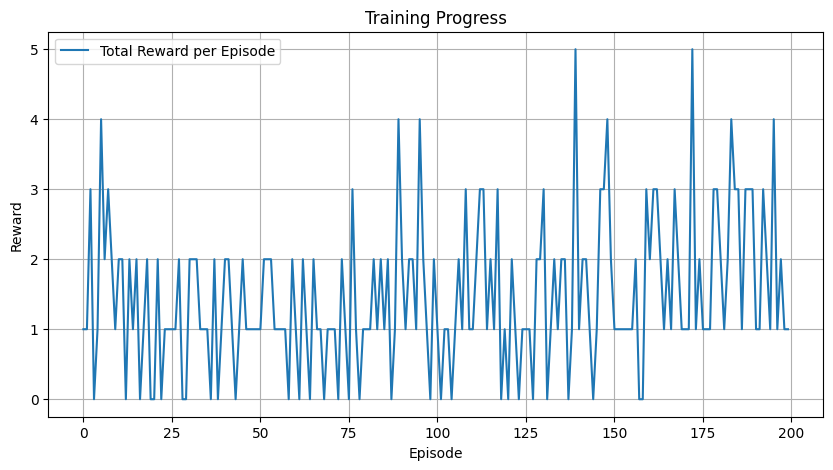

🎬 Видео сохранено: defend_center_dqn.avi


In [24]:
train()  # Обучение и график
test(save_video=True, video_filename="defend_center_dqn.avi")  # Видео игры


In [26]:
from IPython.display import Video

Video("vizdoom_agent_video.mp4", embed=True)
